# NLP Final Project

-----

### ANLY-580: Natural Language Processing

This notebook contains the code required to perform Python script generation as a part of Georgetown University's ANLY-580 Final Project.

Authors:

- Eduardo Armenta (ea795@georgetown.edu)
- Landon Carpenter (lc1276@georgetown.edu)
- Matthew Moriarty (mdm341@georgetown.edu)

In this notebook, we will use a Generative Pre-Trained Transformer (GPT) model in order to generate Python scripts from given English prompts. An example of this is as follows:

```
## Input - English Prompt
"write a python function that computes the maximum of three integers"

## Output - Python Script
def (num1, num2, num3):
  max = num1
  if num2 > max:
    max = num2
  if num3 > max:
    max = num3
  return max
```

In order to accomplish this task, we will heavily utilize `Hugging Face` and `PyTorch`. These resources provide libraries such as `transformers` and `torch` that will be very useful to us in accomplishing our task.

We will also utilize Google Colab in order to obtain the computations resources required for training our model. Here, we can use GPUs - rather than CPUs - to perform the heavy computational tasks required by our model. As such, it is important to find the `Runtime` tab above, navigate to `Change runtime type`, and select the `GPU` hardware accelerator.

**Note**: Please note that, through our vast model training process, we each consumed all our allotted GPU compute time on Google Colab, including that of a Google Colab Pro subscription. As a result, this notebook contains all code required to perform our Python script generation task; however, it does not contain our highest-achieving results. These results, generated prior to consuming our allotted resources, have been included below in the form of screenshots from previous runs. The *current* results appear sub-optimal due to the expiration of resources on the current training session.

# Setup

In this section, we ensure that our Google Colab environment is equipped with the necessary resources before proceeding with our task.

## Installing Necessary Libraries

Before we begin building our models and completing our task, we must ensure that we have the necessary libraries installed. Here, we will install the following:

* `transformers`: this library allows us to access our GPT2 model, tokenizer, and other resources.

In [ ]:
# install transformers
!pip install transformers

Google Colab already has the other libraries that we need installed, such as `torch`, `pandas`, and `numpy`, so we can proceed with importing these libraries into our Python environment.

## Importing Necessary Libraries

With the required libraries installed on Google Colab, we can import them into our Python environment.

In [4]:
# perform necessary imports

# data manipulation libraries
import pandas as pd
import numpy as np

# function for training-testing split
from sklearn.model_selection import train_test_split

# huggingface transformer libraries
import transformers
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import get_linear_schedule_with_warmup

# pytorch libraries
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split

# progress bar for model training
from tqdm.auto import tqdm

# Image library for displaying images
from IPython.display import Image

## Uploading the Data

In order to access the data that we'd like to use for our Python script generation task, we must upload it to Google Colab in a location that is accessible to us. We will upload our data, contained in the `pythonTextData.txt` file, to the current working directory provided by Google Colab.

# Prepare the Data

In this section, we prepare our data for use in our Python script generation task.

## Read in the Data

We first must read in the data. As specified in the previous section, we will be reading this data from the following location: `./pythonTextData.txt`.

In [5]:
# read in the data using a try-catch block for error-handling
try:  
  with open("./pythonTextData.txt", "r", encoding = "utf8") as file:
    # read in the file as a list of lines
    lines = file.readlines()
    # report success and number of lines read in
    print('The data has been read in successfully.')
    print('The data contains', len(lines), 'lines.')
except:
  # report failure by raising exception
  raise Exception('There was a problem reading in the data.')

The data has been read in successfully.
The data contains 42745 lines.


## Preprocess the Data

We have read in our data, but we need to extract the information we need from it. The first several lines of the data look like the following:

```
# write a python program to add two numbers
num1 = 1.5
num2 = 6.3
sum = num1 + num2
print(f'Sum: {sum}')


# write a python function to add two user provided numbers and return the sum
def add_two_numbers(num1, num2):
    sum = num1 + num2
    return sum
```

As we can see, the data is formatted in such a way that each prompt is on a line of its own and starts with a `#` character, just like a Python in-line comment. Each prompt is then followed by one or more lines that define the Python code that completes the task that the prompt raises. Finally, these code blocks are followed by two empty lines before the next prompt appears. We can utilize this structure in order to extract each prompt and its corresponding Python code block.

In [6]:
# collect all indices of lines with '#'
src_indexes = [i for i, line in enumerate(lines) if line.startswith('#')]
# extract all those lines for use in the source column
src = [lines[i].lower() for i in src_indexes]

# collect all the targets by extracting the lines between the indices of the sources
tgt = [''.join(lines[src_indexes[i]+1:src_indexes[i+1]]).lower() for i, value in enumerate(src_indexes[:-1])]
# retrieve the last one as it is not captured by the line above
tgt.append(''.join(lines[src_indexes[-1]+1:]))

# assert that we collected the same number of sources and targets\n",
assert len(src) == len(tgt), 'The number of sources (prompts) collected does not equal the number of targets (code blocks) collected.'

# place source-target pairs into a data frame
python_df = pd.DataFrame({'src':src, 'tgt':tgt})

# create a new column that is the concatenation of each source-target pair
python_df['txt'] = python_df['src'] + ' | ' + python_df['tgt']

It's important to visually observe what we have done in our preprocessing steps, so let's take a look at the first few rows of the data frame.

In [7]:
# display the first five rows of the data frame
python_df.head(5)

,src,tgt,txt
0,# write a python program to add two numbers \n,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...,# write a python program to add two numbers \n...
1,# write a python function to add two user prov...,"def add_two_numbers(num1, num2):\n sum = nu...",# write a python function to add two user prov...
2,# write a program to find and print the larges...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...,# write a program to find and print the larges...
3,# write a program to find and print the smalle...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...,# write a program to find and print the smalle...
4,# write a python function to merge two given l...,"def merge_lists(l1, l2):\n return l1 + l2\n...",# write a python function to merge two given l...


The last task that we want to complete here is splitting the data into training and testing sets. In the unique case of our Python script generation task, we will actually retain nearly all the data for model training and hold out **10** prompts for testing. We believe that this will allow our model to train as fully as it can, while still allowing us to use prompts from the data for testing.

We can print the shape of each data frame in order to ensure that this split is performed correctly. With 4,958 initial source-target pairs, we should see that **4,948** are kept in the training set and **10** are placed in the testing set.

In [8]:
# retain 10 prompts for testing, keep the rest for training
python_df_train, python_df_test = train_test_split(python_df, test_size = 10)

# report the shape of each set
print('Training Set Shape:', python_df_train.shape)
print('Testing Set Shape:', python_df_test.shape)

Training Set Shape: (4948, 3)
Testing Set Shape: (10, 3)


# Construct the Model

In this section, we will prepare the rest of our resources for our Python script generation task. Here, we will create our model using the `GPT2Tokenizer` and the `GPT2LMHeadModel` from the `transformers` library, create a simple `Dataset` class specific to our task, and utilize the `DataLoader` from the `torch.utils` library in order to provide our data to our model.

## Define Hyperparameters

We can first define some hyperparameters that we will use throughout this section. These include:

* `bsize`: the batch size to use when batching data
* `epochs`: the number of epochs to use in training
* `lr_init`: the initial rate by which the model learns
* `warmup_steps`: the number of steps to take during training before utilizing the initialized learning rate

Note that we will use a very small batch size (`bsize = 2`) in order to preserve limited memory resources on Google Colab's GPU.


In [ ]:
# define hyperparameters
bsize = 2
epochs = 5
lr_init = 1e-5
warmup_steps = 100

## Build the Tokenizer

We will retrieve our tokenizer using the pretrained `gpt2` option provided by Hugging Face. We also include additional special tokens, as follows:

* Beginning of Sentence (BOS) Token: `<SOS>`
* End of Sentence (EOS) Token: `<EOS>`
* Pad (PAD) Token: `<PAD>`

In [ ]:
# initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<SOS>', eos_token='<EOS>', pad_token='<PAD>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Build the Dataset

We will use `torch.utils.data`'s `Dataset` and `DataLoader` features in order to construct our dataset in such a way that is compatible with our model (<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">PyTorch: Datasets & DataLoaders</a>).

First, we will create a class `Python_Dataset` using `torch.utils.data`'s `Dataset`.

In [ ]:
# 'Python_Dataset' class for our python text data
class Python_Dataset(Dataset):

  # we need an __init__ function
  def __init__(self, input_txt, input_tokenizer):# do we need these?, gpt2_type="gpt2", max_length=768):

    # store the incoming tokenizer as an attribute of the instance
    self.tokenizer = input_tokenizer
    # create attributes to store input IDs and attention masks
    self.input_ids_list = []; self.attention_mask_list = []

    # iterate through each source-target pair
    for txt in input_txt:
      # encode the text using special tokens defined above
      encodings_dict = input_tokenizer('<SOS>'+ txt + '<EOS>', truncation = True, padding = "max_length") # , max_length = max_length)
      # store the encoded input IDs and attention mask as tensors
      input_ids = torch.tensor(encodings_dict['input_ids'])
      attention_mask = torch.tensor(encodings_dict['attention_mask'])
      # append the input IDs and attention mask to the class attribute lists
      self.input_ids_list.append(input_ids)
      self.attention_mask_list.append(attention_mask)

  # we need a __len__ function 
  def __len__(self):
    # return the number of lists of input IDs gathered (should match number of texts)
    return len(self.input_ids_list)

  # we need a __getitem__ function
  def __getitem__(self, idx):
    # return a tuple of the input IDs and attention mask for the current item
    return self.input_ids_list[idx], self.attention_mask_list[idx] 

Next, we will create an instance of the `Python_Dataset` class using the class constructor and the data frame that we stored our training data in, `python_df_train`.

In [ ]:
# create instance of Python_Dataset class
python_dataset_train = Python_Dataset(python_df_train['txt'], tokenizer)

Now, we can wrap an *iterable* around our dataset using `torch.utils.data`'s `DataLoader`. According to documentation for this feature, wrapping an iterable around the dataset allows the observations within the dataset to be more easily accessed.

We can once again ensure that our data has been loaded properly by observing the length of our DataLoader object. Using a batch size of 2, we can expect the DataLoader to have ceil($\frac{4948}{2}$)= **2,474** batches.

In [ ]:
# create the data loader for the training set
train_batches = DataLoader(python_dataset_train, batch_size = bsize)

# report the number of loaded batches for the training set
print('Number of Training Batches:', len(train_batches))

Number of Training Batches: 2474


## Build the Model

We will use `transformers`' `GPT2LMHeadModel` here in order to retrieve our model. Using the `gpt2` option as we used with the tokenizer, we can retrieve a manageable version of GPT2.

We must also resize the token embeddings here, as we have added special tokens to our tokenizer (`<SOS>`, `<EOS>`, and `<PAD>`). This way, our pretrained tokenizer and model can be compatible with one another.

In [ ]:
# initialize the model using gpt2
model = GPT2LMHeadModel.from_pretrained("gpt2")

# resize token embeddings, as explained above
model.resize_token_embeddings(len(tokenizer));

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Since our model will require strong computational resources, we could place the model directly on Google Colab's GPU, but we opt for a safer way of doing so. Below, we only place the model on the GPU if it is available.

In [1]:
# send the model to the available device
if torch.cuda.is_available():
  # if available, use GPU
  device = torch.device('cuda:0')
else:
  # otherwise, use CPU
  device = torch.device('cpu')

# push the model to the selected device
model.to(device);

# report the device that the model was pushed to
print('The model has been pushed to device:', device)

The model has been pushed to device: cuda:0


We can also initialize our optimizer and create a scheduled learning rate. These components will allow our model to learn in a more constructive way, rather than a more erratic one.

Note that we use `torch.optim.AdamW` here, rather than `transformers.AdamW`, because the latter is deprecated.

In [ ]:
# initialize optimizer
optimizer = AdamW(model.parameters(), lr = lr_init)

# initialize a scheduled learning rate
lr = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = warmup_steps, 
    num_training_steps = len(train_batches))

# Train the Model

In this section, we train our model using all the features that we have organized. We define a function, `runner`, to execute the training process and call that function using our training data.

In [ ]:
# runner function to train the model
def runner(batches):

  # prepare for training
  model.train()

  # train the model over the number of specified epochs
  for epoch in range(epochs):

    # start a progress bar, which will help for observing runtime
    print('Training: Epoch', epoch + 1)
    progress_bar = tqdm(range(len(batches)))

    # iterate through all batches
    for batch in batches:

      # extract the input IDs (position 0)
      input_ids = batch[0].to(device)
      labels = batch[0].to(device)
      # extract the attention masks (position 1)
      attention_masks = batch[1].to(device)       

      # retrieve the outputs of the model
      outputs = model(input_ids,
                      labels = labels, 
                      attention_mask = attention_masks,
                     ) 

      # compute loss and backpropogate
      loss = outputs.loss
      loss.backward()
      # advance the optimizer and learning rates
      optimizer.step()
      lr.step()
      # zero out gradients so they won't affect the next batch
      optimizer.zero_grad()

      # update the progress bar
      progress_bar.update(1)

In [ ]:
# train the model using the function above
runner(train_batches)

Training: Epoch 1


  0%|          | 0/2479 [00:00<?, ?it/s]

Training: Epoch 2


  0%|          | 0/2479 [00:00<?, ?it/s]

Training: Epoch 3


  0%|          | 0/2479 [00:00<?, ?it/s]

Training: Epoch 4


  0%|          | 0/2479 [00:00<?, ?it/s]

Training: Epoch 5


  0%|          | 0/2479 [00:00<?, ?it/s]

# Test the Model

In this section, we use the 10 held-out test prompts in order to test our model. Using these prompts, we can generate responses from the model and decode them into Python scripts. Below, we create a function that does this for us, calling the function once for each test prompt.

In [ ]:
def generate_from_prompt(prompt):

  # encode the prompt and extract the input IDs and attention mask
  encoded_prompt = tokenizer(prompt)
  input_ids = torch.tensor(encoding['input_ids']).to(device).unsqueeze(0)
  attention_mask = torch.tensor(encoding['attention_mask']).to(device).unsqueeze(0)

  # extract the IDs given to the special tokens
  bos = torch.tensor(tokenizer.encode('<SOS>')).to(device)
  eos = torch.tensor(tokenizer.encode('<EOS>')).to(device)
  pad = torch.tensor(tokenizer.encode('<PAD>')).to(device)

  # generate response to prompt
  response = model.generate(input_ids = input_ids,
                            attention_mask = attention_mask,
                            bos_token_id = bos,
                            eos_token_id = eos,
                            pad_token_id = pad,
                            max_length = 200,
                            top_p = 0.95,
                            num_return_sequences = 1
                            )
  
  # decode and return the response
  python_code = tokenizer.decode(sample_output, skip_special_tokens = True)
  return python_code

In [ ]:
# collect the prompts from the testing data
test_prompts = python_df_test['src']

# call the function above on each prompt to generate output
for i, test_prompt in enumerate(test_prompts):
  print('--- Test Prompt', i, '---')
  print(test_prompt)
  print('Generated Output', i)
  print(generate_from_prompt(test_prompt))
  print('\n\n')

**Note**: Please note that we do not provide output for the function calls above due to what we mentioned in our introduction. As mentioned, we have run out of GPU resources on Google Colab, so we are not currently able to train our model one final time in order to test these held-out prompts.

However, we were able to retain a handful of results through our training process by keeping outputs and taking screenshots of test results when possible. We provide these below.

### Example 1

Our first example is a retainment of prior model output and can be seen below.

In [ ]:
# generate python script from made-up prompt
generate_from_prompt('# write a function that sums two integers | ')

0:  # write a function that sums two integers |     
#
                   
            
if((

      
[1]

{

is a function


[
]
}



set of





     








 1

1 1

1
1

2 a




### Example 2

Our second example is another retainment of prior model output and can also be seen below.

In [ ]:
# generate python script from made-up prompt
generate_from_prompt('<SOS> # write a function that sorts a list | ')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257,  1303,  3551,   257,  2163,   326, 10524,   257,  1351,   930,
           220]], device='cuda:0')
0:  # write a function that sorts a list |    = [] def filter_list(list):     = list[list[ 0 ]][1] 
return list[list] #
     print (list[ 0 ][ 0 ])
 
else:
    def iter_list(list):        = list[list[ 0 ]) 
# a number of values to use if no empty list
       print (list[ 0 ]):     print (list[ 0 ])
  else:    def iter_list(list):        = list[list[ 0 ], 3]    print (list[ 3]:    print ("", list[ 2 ])
     if len(list[ 0 ][ 1]) >= 3:    print(" ", list[0]):     print(" ", list[ 0 ][1])     if len(list[ 3 ][ 2]) >= 2:   print(" ", list

]   return list[3][ 2]
 # print("", list[0][1])

# print(" ", list[0][




### Example 3

Our third example is provided as a screenshot and was generated from our highest-achieving model with the help of Google Colab's GPU resources. This can be seen below.

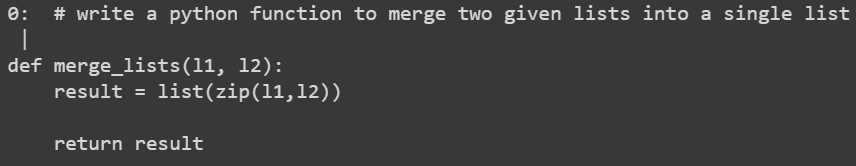

In [ ]:
# display screenshot from previous test prompt
Image(filename='merge_two_lists.png')

### Example 4

Our fourth example is also provided as a screenshot and was generated from our highest-achieving model with the help of Google Colab's GPU resources. This can be seen below.

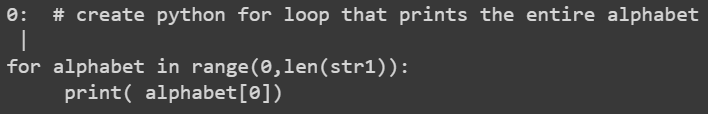

In [ ]:
# display screenshot from previous test prompt
Image(filename='for loop.png')

# Future Work

In this section, as we wrap up our analysis, we would like to propose several ideas for future work.

### More Thorough Training

The most glaring place for improvement that we see with our analysis lies in the model training process. Of course, as mentioned, we were able to run our models using Google Colab's GPU resources to a certain extent, but eventually exhausted those resources. We believe that having access to more powerful resources while training our model would lead us to more successful results in the future.

### More Data

Another place for improvement that we recognize relates to the size of our data. Although we have nearly 5,000 prompts and associated Python code blocks, our dataset still remains very small at approximately 1.1 MB. We realize that having access to more data for use in our model training process could also lead to more desirable results in the future.

One way in which we can increase the size of our dataset is through *Data Augmentation*. Here, we can replace variable names in the Python code blocks in order to generate similar but different code blocks for each prompt. This way, we increase the size of our dataset and allow our model to get a better understanding of Python syntax and structure, rather than focusing on variable names themselves.

### Optimize the Model

The last article of improvement that we would like to recognize regards the model itself. With more exhaustive hyperparameter tuning, we believe that we could improve our results. For instance, given unlimited resources, we would like to experiment with differing batch sizes, scheduled learning rates, and model choices. With this approach, we believe that we could find the optimal parameters for our model.

# References

PyTorch: Datasets & DataLoaders: (<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">PyTorch</a>)

Moving NLP Forward: (<a href="https://www.youtube.com/watch?v=WVM09Ri4MbI">Youtube</a>)

GPT-2 Fine-Tuning: (<a href="https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=v4XhewaV93-_">Google Colab</a>)

Fine-Tuning GPT-2: (<a href="https://github.com/itsuncheng/fine-tuning-GPT2">GitHub</a>)

GPT-2 Resources: (<a href="https://drive.google.com/drive/folders/12kc9BrHdEe2am4x7d_x0YyKAGd0PeuuS">Google Drive</a>)

Fine-Tuning GPT-2 for Text Generation: (<a href="https://towardsdatascience.com/fine-tuning-gpt2-for-text-generation-using-pytorch-2ee61a4f1ba7">Toward Data Science</a>)